### Importujemy biblioteki

In [2]:
#niezbędne biblioteki
import gym
import random
import numpy as np
import tensorflow as tf
from skimage import data
from skimage.color import rgb2gray
from keras import backend as K
from keras.models     import Sequential, Model
from keras.layers     import Dense, Conv2D, Flatten, MaxPooling2D, Input, Lambda
from keras.optimizers import Adam
from keras.utils import np_utils
from keras.models import model_from_json
from sklearn.preprocessing import StandardScaler
from collections import deque
import h5py
import matplotlib.pyplot as plt

Using TensorFlow backend.


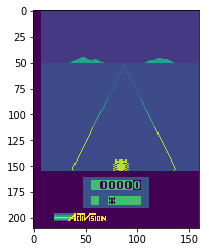

In [21]:
env = gym.make('Enduro-v0')
plt.imshow(rgb2gray(env.reset()))


### Preprocesing ramek
Obcinamy część ramki bo zawiera nieistotne informacje informacje. Resztę przedstawiamy jako obrazek czarno biały i normalizujemy wartosci

In [3]:
def preprocess_frame(frame):
    img=rgb2gray(frame)
    img=img[50:155,:]
    img=img/255
    img=img.reshape(*img.shape, -1)
    return img

def stack_frames(stacked_frames, state, is_new_episode):
        frame = preprocess_frame(state)
        if is_new_episode:
            #Czyścimy stos
            stacked_frames = deque([np.zeros((105,160), dtype=np.int) for i in range(4)], maxlen=4)
            
            #Na pocżatku nowej gry nie mamy stosu, więc go tworzymy
            stacked_frames.append(frame)
            stacked_frames.append(frame)
            stacked_frames.append(frame)
            stacked_frames.append(frame)

            stacked_state = np.stack(stacked_frames, axis=2)

        else:
            # Append frame to deque, automatically removes the oldest frame
            stacked_frames.append(frame)

            # Build the stacked state (first dimension specifies different frames)
            stacked_state = np.stack(stacked_frames, axis=2) 

        return stacked_state, stacked_frames

In [25]:
#piszemy klasę, która będzie odpowiadała za działania naszego agenta
class DQNSuperAgent:
    def __init__(self, state_size):
        self.state_size = state_size
        self.memory = deque(maxlen=5000)
        self.gamma = 0.95    # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.model = self._build_model()
    def _build_model(self):
        model = Sequential()
        model.add(Conv2D(32, (5,5), strides=3, input_shape=(105, 160, 4), activation='elu'))
        model.add(Conv2D(60, (4,4), strides=2, activation='elu'))
        model.add(Conv2D(60, (3,3), activation='elu'))
        model.add(MaxPooling2D())
        model.add(Flatten())
        model.add(Dense(150, activation='relu'))
        model.add(Dense(4, activation='linear'))
        model.compile(loss='mse',
                      optimizer=Adam(lr=self.learning_rate))
        return model
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randint(0,3)
        else:
            state=state.reshape(1, *state.shape)
            act_values = self.model.predict(state)
            return np.argmax(act_values[0]) #Wybieramy akcję o największej przewidywanej nagrodzie
    def replay(self, batch_size):
        minibatch = np.array(self.memory)[:batch_size]
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                next_state=next_state.reshape(1, *next_state.shape)
                target = reward + self.gamma * np.amax(self.model.predict(next_state)[0]) #to [0] bierze się stąd, że ramka 
                #z wynikami jest w innej ramce
            state=state.reshape(1, *state.shape)
            target_f = self.model.predict(state)
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

In [4]:
#klasa z zaimplementowaną rywalizującą siecią neuronową
class DuelingAgent:
    def __init__(self, state_size):
        self.state_size = state_size
        self.memory = deque(maxlen=10000)
        self.gamma = 0.95    # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.model = self._build_model()
    def _build_model(self):
        # Uses the network architecture found in DeepMind paper
        model = Sequential()
        input_layer = Input(shape = (105, 160,1))
        conv1 = Conv2D(32, (9,9), strides=3, padding='same', activation='relu')(input_layer)
        max1 = MaxPooling2D((2,2))(conv1)
        conv2 = Conv2D(64, (5, 5), strides=2, activation='relu')(max1)
        conv3 = Conv2D(64, (3, 3), activation = 'relu')(conv2)
        flatten = Flatten()(conv3)
        fc1 = Dense(512)(flatten)
        advantage = Dense(4)(fc1)
        fc2 = Dense(512)(flatten)
        value = Dense(1)(fc2)
        policy = Lambda(lambda x: x[0]-K.mean(x[0])+x[1], output_shape = (4,))([advantage, value])
        model = Model(input=[input_layer], output=[policy])
        model.compile(loss='mse',
                      optimizer=Adam(lr=self.learning_rate))
        return model
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randint(0,3)
        else:
            state=state.reshape(1, *state.shape)
            act_values = self.model.predict(state)
            return np.argmax(act_values[0]) #Wybieramy akcję o największej przewidywanej nagrodzie
    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                next_state=next_state.reshape(1, *next_state.shape)
                target = reward + self.gamma * np.amax(self.model.predict(next_state)[0]) #to [0] bierze się stąd, że ramka 
                #z wynikami jest w innej ramce
            state=state.reshape(1, *state.shape)
            target_f = self.model.predict(state)
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

In [10]:
#obecnie niedziałająca realizacja z stackowaniem klatek
if __name__ == "__main__":
    # initialize gym environment and the agent
    env = gym.make('Enduro-v0')
    agent = DuelingAgent(env)
    episodes=400
    stack_size = 4 # We stack 4 frames
    # Initialize deque with zero-images one array for each image
    stacked_frames  =  deque([np.zeros((105,160), dtype=np.int) for i in range(stack_size)], maxlen=4) 
    # Iterate the game
    for e in range(episodes):
        score = 0
        # reset state in the beginning of each game
        state = env.reset()
        cars=0
        max_cars=0
        for time_t in range(5000):
            if time_t==0:
                state, stacked_frames = stack_frames(stacked_frames, state, True)
                action = agent.act(state)
                # Advance the game to the next frame based on the action.
                # Reward is 1 for every frame the pole survived
                next_state, reward, done, _ = env.step(action)
                if reward==1:
                    cars+=1
                    reward=10
                    if cars>max_cars:
                        max_cars=cars
                        reward+=100
                if reward==-1:
                    cars-=1
                    reward=-10
                score=score+reward
            # turn this on if you want to render
            # env.render()
            else:
                action = agent.act(state)
                # Advance the game to the next frame based on the action.
                # Reward is 1 for every frame the pole survived
                next_state, reward, done, _ = env.step(action)
                if reward==1:
                    cars+=1
                    reward=10
                    if cars>max_cars:
                        max_cars=cars
                        reward+=100
                if reward==-1:
                    cars-=1
                    reward=-10
                score=score+reward
                next_state, stacked_frames = stack_frames(stacked_frames, next_state, False)
                # Remember the previous state, action, reward, and done
                agent.remember(state, action, reward, next_state, done)
                # make next_state the new current state for the next frame.
                state = next_state
                # done becomes True when the game ends
                # ex) The agent drops the pole
            if done or time_t==4999:
                # print the score and break out of the loop
                print("episode: {}/{}, score: {}, cars: {}"
                      .format(e+1, episodes, score, cars))
                break
        # train the agent with the experience of the episode
        agent.replay(1500)

/home/arkadiusz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=[<tf.Tenso...)`


episode: 1/400, score: 500.0, cars: 0


ValueError: Error when checking input: expected input_3 to have 4 dimensions, but got array with shape (1, 105, 160, 4, 1)

In [8]:
#realizacja ze stackowaniem klatek
if __name__ == "__main__":
    # initialize gym environment and the agent
    env = gym.make('Enduro-v0')
    agent = DuelingAgent(env)
    episodes=400
    #stack_size = 4 # We stack 4 frames
    # Initialize deque with zero-images one array for each image
    #stacked_frames  =  deque([np.zeros((105,160), dtype=np.int) for i in range(stack_size)], maxlen=4) 
    # Iterate the game
    for e in range(episodes):
        score = 0
        # reset state in the beginning of each game
        state = preprocess_frame(env.reset())
        cars=0
        max_cars=0
        for time_t in range(5000):           
            action = agent.act(state)
            # Advance the game to the next frame based on the action.
            # Reward is 1 for every frame the pole survived
            next_state, reward, done, _ = env.step(action)
            score=score+reward
            next_state = preprocess_frame(next_state)
            # Remember the previous state, action, reward, and done
            agent.remember(state, action, reward, next_state, done)
            # make next_state the new current state for the next frame.
            state = next_state
            # done becomes True when the game ends
            # ex) The agent drops the pole
            if done or time_t==4999:
                # print the score and break out of the loop
                print("episode: {}/{}, score: {}, cars: {}"
                      .format(e+1, episodes, score, cars))
                break
        # train the agent with the experience of the episode
        agent.replay(1500)

/home/arkadiusz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=[<tf.Tenso...)`


episode: 1/400, score: 0.0, cars: 0
episode: 2/400, score: 0.0, cars: 0
episode: 3/400, score: 0.0, cars: 0
episode: 4/400, score: 0.0, cars: 0
episode: 5/400, score: 0.0, cars: 0
episode: 6/400, score: 2.0, cars: 0
episode: 7/400, score: 0.0, cars: 0
episode: 8/400, score: 1.0, cars: 0
episode: 9/400, score: 0.0, cars: 0
episode: 10/400, score: 0.0, cars: 0
episode: 11/400, score: 0.0, cars: 0
episode: 12/400, score: 0.0, cars: 0
episode: 13/400, score: 0.0, cars: 0
episode: 14/400, score: 0.0, cars: 0
episode: 15/400, score: 10.0, cars: 0
episode: 16/400, score: 0.0, cars: 0
episode: 17/400, score: 0.0, cars: 0
episode: 18/400, score: 0.0, cars: 0
episode: 19/400, score: 0.0, cars: 0
episode: 20/400, score: 0.0, cars: 0
episode: 21/400, score: 2.0, cars: 0
episode: 22/400, score: 0.0, cars: 0
episode: 23/400, score: 1.0, cars: 0
episode: 24/400, score: 0.0, cars: 0
episode: 25/400, score: 0.0, cars: 0
episode: 26/400, score: 2.0, cars: 0
episode: 27/400, score: 1.0, cars: 0
episode: 

episode: 219/400, score: 0.0, cars: 0
episode: 220/400, score: 0.0, cars: 0
episode: 221/400, score: 0.0, cars: 0
episode: 222/400, score: 33.0, cars: 0
episode: 223/400, score: 11.0, cars: 0
episode: 224/400, score: 1.0, cars: 0
episode: 225/400, score: 0.0, cars: 0
episode: 226/400, score: 0.0, cars: 0
episode: 227/400, score: 0.0, cars: 0
episode: 228/400, score: 0.0, cars: 0
episode: 229/400, score: 0.0, cars: 0
episode: 230/400, score: 0.0, cars: 0
episode: 231/400, score: 0.0, cars: 0
episode: 232/400, score: 0.0, cars: 0
episode: 233/400, score: 0.0, cars: 0
episode: 234/400, score: 10.0, cars: 0
episode: 235/400, score: 0.0, cars: 0
episode: 236/400, score: 6.0, cars: 0
episode: 237/400, score: 0.0, cars: 0
episode: 238/400, score: 9.0, cars: 0
episode: 239/400, score: 0.0, cars: 0
episode: 240/400, score: 0.0, cars: 0
episode: 241/400, score: 0.0, cars: 0
episode: 242/400, score: 0.0, cars: 0
episode: 243/400, score: 0.0, cars: 0
episode: 244/400, score: 0.0, cars: 0
episode: 

### Zapisujemy uzyskany model

In [14]:
model_dobry = agent.model.to_json()
with open("model_nowy_pre.json", "w") as json_file:
    json_file.write(model_dobry)
agent.model.save_weights("model_nowy_pre.h5")

### I wczytujemy

In [6]:
json_file = open('model_nowy_pre.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights("model_nowy_pre.h5")

Instructions for updating:
Colocations handled automatically by placer.


In [7]:
env = gym.make('CartPole-v0')
env.reset()
for _ in range(1000):
    env.render()
    env.step(env.action_space.sample()) # take a random action
env.close()

## Testujemy model

In [6]:
def testuj(model, stack=False):
    env = gym.make('Enduro-v0')
    scores = []
    choices = []
    for each_game in range(5):
        score = 0
        prev_obs = []
        stack_size = 4 
        stacked_frames  =  deque([np.zeros((105,160), dtype=np.int) for i in range(4)], maxlen=4)
        state = env.reset()
        for step_index in range(5000):
            env.render()
            if stack:
                if step_index==0:
                    state, stacked_frames = stack_frames(stacked_frames, state, True)
                    action=random.randint(1,3)
                else:
                    action = np.argmax(model.predict(prev_obs))
                new_observation, reward, done, info = env.step(action)
                prev_obs, stacked_frames = stack_frames(stacked_frames, new_observation, False)
                prev_obs=prev_obs.reshape(1, *prev_obs.shape)
                score+=reward
                
                if done:
                    break
                
            else:
                if step_index==0:
                    action=random.randint(1,3)
                else:
                    action = np.argmax(model.predict(prev_obs))
                choices.append(action)
                new_observation, reward, done, info = env.step(action)
                prev_obs = preprocess_frame(new_observation)
                prev_obs=prev_obs.reshape(1, *prev_obs.shape)
                score+=reward
                
                if done:
                    break
        env.reset()
        scores.append(score)
    env.close()

    print(scores)
    print('Average Score:', sum(scores)/len(scores))
    #print('choice 1:{}  choice 2:{}'.format(choices.count(1)/len(choices),choices.count(2)/len(choices)))

In [9]:
testuj(agent.model, False)

[22.0, 22.0, 34.0, 16.0, 16.0]
Average Score: 22.0
